In [1]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Data Preprocessing

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.2 MB/s eta 0:00:00


## ICA visualization

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


<ipython-input-29-9b462be73c33>:59: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.


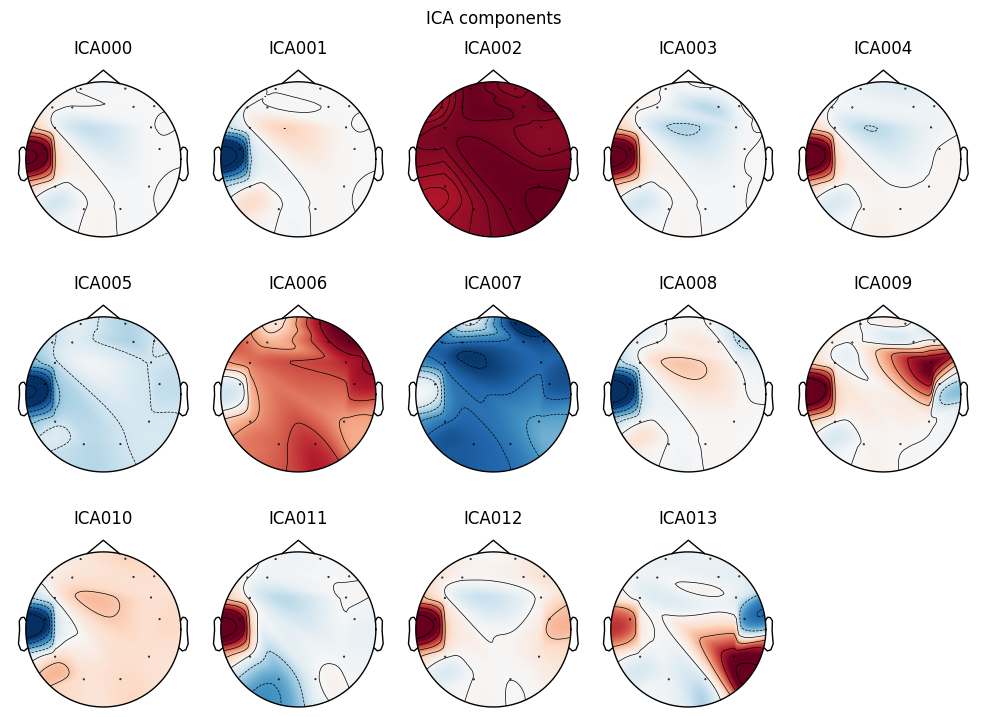

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
import mne
import os

def high_pass_filter(data, sfreq, l_freq):
    """
    Apply a high-pass filter to the data.

    Parameters:
    data (numpy.ndarray): The EEG data.
    sfreq (float): The sampling frequency of the data.
    l_freq (float): The lower bound of the high-pass filter.

    Returns:
    numpy.ndarray: The filtered data.
    """
    # Design high-pass filter
    nyquist = 0.5 * sfreq
    normal_cutoff = l_freq / nyquist
    b, a = butter(1, normal_cutoff, btype='high', analog=False)

    # Apply the filter
    filtered_data = lfilter(b, a, data, axis=1)
    return filtered_data

def ica_comp_viz(file_path):
    """
    Visualize ICA components for EEG data artifact removal.

    Parameters:
    file_path (str): Path to the EEG data file.
    """
    # Load the data
    data = pd.read_csv(file_path, sep="\s+", header=None)

    # Prepare EEG data for ICA
    eeg_data = data.values.T
    sfreq = 128  # Sampling frequency
    l_freq = 1.0  # High-pass filter lower bound

    # Apply high-pass filter
    eeg_data = high_pass_filter(eeg_data, sfreq, l_freq)

    # Create MNE info structure
    ch_names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

    # Create RawArray
    raw = mne.io.RawArray(eeg_data, info)

    # Set a standard montage (electrode locations)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    # Apply ICA
    ica = mne.preprocessing.ICA(n_components=14, max_iter=1000, random_state=97)
    ica.fit(raw)

    # Visualize ICA components
    ica.plot_components(inst=raw)

# Example usage
file_path = "/content/drive/MyDrive/EEG Analysis/STEW Dataset/sub01_lo.txt"
ICA_Viz = ica_comp_viz(file_path)


## Artifact & noise removal

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
import mne
import os


# Function to load and preprocess the EEG data
def load_and_preprocess_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep="\s+", header=None)

    # Artifact Removal using ICA
    eeg_data = data.values.T
    info = mne.create_info(ch_names=[str(i) for i in range(14)], sfreq=128, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)
    ica = mne.preprocessing.ICA(n_components=14, random_state=97)
    ica.fit(raw)
    ica.exclude = [0, 3, 4, 7]  # Assume components 0 and 1 are artifacts

    # Apply ICA to remove the artifacts
    raw_ica = ica.apply(raw)

    # Band-pass Filtering
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def bandpass_filter(data, lowcut=0.5, highcut=50.0, fs=128, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

    filtered_data = bandpass_filter(raw_ica.get_data())

    return filtered_data

# Path to the dataset folder
dataset_folder_path = '/content/drive/MyDrive/EEG Analysis/STEW Dataset'


# # Initialize lists to store the data and labels
all_data = []
labels = []
labels_binary=[]

# Read the ratings from the ratings.txt file
ratings_file_path = os.path.join(dataset_folder_path, 'ratings.txt')
subject_ratings = {}

with open(ratings_file_path, 'r') as ratings_file:
    for line in ratings_file:
        parts = line.strip().split(',')
        subject_number = int(parts[0])
        if len(parts) == 3:  # Ensure that there are exactly 3 parts in the line
            rating_rest = int(parts[1])
            rating_test = int(parts[2])
            subject_ratings[subject_number] = (rating_rest, rating_test)

# Process each EEG data file
for file_name in os.listdir(dataset_folder_path):
    if file_name.endswith('.txt') and 'ratings' not in file_name:
        file_path = os.path.join(dataset_folder_path, file_name)


        # Extract subject number from the file name
        subject_number = int(file_name.split('_')[0][3:5])  # Adjust according to your file naming convention

        # Check if ratings are available for the subject
        if subject_number in subject_ratings:
            preprocessed_data = load_and_preprocess_data(file_path)

            all_data.append(preprocessed_data)

            # Append the ratings to the labels lists
            rating_rest, rating_test = subject_ratings[subject_number]
            if file_name.split('_')[1][0:2]=="lo":
                labels.append(rating_rest)
            else:
                labels.append(rating_test)

            # Append the ratings to the binary labels lists
            rating_rest, rating_test = subject_ratings[subject_number]
            if file_name.split('_')[1][0:2]=="lo":
                labels_binary.append(0)
            else:
                labels_binary.append(1)

# Convert to numpy arrays
all_data = np.array(all_data)
print(np.shape(all_data))
labels = np.array(labels)
labels_binary = np.array(labels_binary)

# Save the preprocessed data
np.save('/content/drive/MyDrive/EEG Analysis/preprocessed_eeg_data.npy', all_data)
np.save('/content/drive/MyDrive/EEG Analysis/eeg_labels.npy', labels)
np.save('/content/drive/MyDrive/EEG Analysis/eeg_labels_binary.npy', labels_binary)


#Feature Extraction

In [2]:
!pip install pyentrp
!pip install antropy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.1 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16880 sha256=5563c7d2e2f9d384873a37f7ebc9cfe26648bded0905412ba91ee9efde9c0943
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [130]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import antropy as an

# Define frequency bands
frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 50)
}

# Function to compute Power Spectral Density (PSD) and related features
def compute_psd_features(data, sfreq):
    freqs, psd = welch(data, sfreq)
    mean_psd = np.mean(psd, axis=1)
    std_psd = np.std(psd, axis=1)

    band_features = {}
    for band, (low_freq, high_freq) in frequency_bands.items():
        band_mask = (freqs >= low_freq) & (freqs <= high_freq)
        band_psd = psd[:, band_mask]
        band_features[f'mean_PSD_{band}'] = np.mean(band_psd, axis=1)
        band_features[f'STD_PSD_{band}'] = np.std(band_psd, axis=1)

    return mean_psd, std_psd, band_features

# Function to compute amplitude-related features
def compute_amplitude_features(data):
    mean_amp = np.mean(data, axis=1)
    std_amp = np.std(data, axis=1)
    var_amp = np.var(data, axis=1)
    range_amp = np.ptp(data, axis=1)
    skew_amp = skew(data, axis=1)
    kurt_amp = kurtosis(data, axis=1)
    return mean_amp, std_amp, var_amp, range_amp, skew_amp, kurt_amp

# Function to compute entropy features
def compute_entropy_features(data):
    perm_entropy = np.array([an.perm_entropy(d, order=3, normalize=True) for d in data])
    spectral_entropy = np.array([an.spectral_entropy(d, sf=128, method='welch', normalize=True) for d in data])
    svd_entropy = np.array([an.svd_entropy(d, order=3, delay=1, normalize=True) for d in data])
    approx_entropy = np.array([an.app_entropy(d, order=2, metric='chebyshev') for d in data])
    sample_entropy = np.array([an.sample_entropy(d, order=2, metric='chebyshev') for d in data])
    return perm_entropy, spectral_entropy, svd_entropy, approx_entropy, sample_entropy

# Function to compute fractal dimension features
def compute_fractal_features(data):
    petrosian_fd = np.array([an.petrosian_fd(d) for d in data])
    katz_fd = np.array([an.katz_fd(d) for d in data])
    higuchi_fd = np.array([an.higuchi_fd(d, kmax=10) for d in data])
    return petrosian_fd, katz_fd, higuchi_fd

# Function to compute detrended fluctuation analysis
def compute_dfa(data):
    dfa = np.array([an.detrended_fluctuation(d) for d in data])
    return dfa

# Load numpy arrays
all_data = np.load('/content/drive/MyDrive/EEG Analysis/preprocessed_eeg_data.npy')
labels = np.load('/content/drive/MyDrive/EEG Analysis/eeg_labels.npy')

# Initialize DataFrame to store features
features_list = []

# Parameters
sfreq = 128  # Sampling frequency
window_size = 30 * sfreq  # Window size for 30 seconds
overlap = 0.5  # 50% overlap
num_channels = all_data.shape[1]

for i, data in enumerate(all_data):
    num_segments = int ( data.shape[1] // (window_size * overlap) ) -1
    print("Number of iteration:" , i)
    for seg in range(num_segments):
        start = int (seg * window_size * overlap)
        end = int (start + window_size)
        segment_data = data[:, start:end]

        # Compute PSD features
        mean_psd, std_psd, band_features = compute_psd_features(segment_data, sfreq=128)

        # Compute amplitude features
        mean_amp, std_amp, var_amp, range_amp, skew_amp, kurt_amp = compute_amplitude_features(segment_data)

        # Compute entropy features
        perm_entropy, spectral_entropy, svd_entropy, approx_entropy, sample_entropy = compute_entropy_features(segment_data)

        # Compute fractal dimension features
        petrosian_fd, katz_fd, higuchi_fd = compute_fractal_features(segment_data)

        # Compute DFA
        dfa = compute_dfa(segment_data)

        # Append features to the list
        feature_row = {
            "mean_PSD": mean_psd.mean(),
            "STD_PSD": std_psd.mean(),
            "A_mean": mean_amp.mean(),
            "A_STD": std_amp.mean(),
            "A_Var": var_amp.mean(),
            "A_range": range_amp.mean(),
            "A_skew": skew_amp.mean(),
            "A_kurtosis": kurt_amp.mean(),
            "Permutation_E": perm_entropy.mean(),
            "Spectral_E": spectral_entropy.mean(),
            "Sample_E": sample_entropy.mean(),
            "SVD_E": svd_entropy.mean(),
            "Approximate_E": approx_entropy.mean(),
            "Petrosian_FD": petrosian_fd.mean(),
            "Katz_FD": katz_fd.mean(),
            "Higuchi_FD": higuchi_fd.mean(),
            "Detrended_fluctuation_analysis": dfa.mean(),
        }

        # Add band-specific PSD features
        for feature, values in band_features.items():
            feature_row[f"{feature}"] = values.mean()

        feature_row ["Label"] = labels[i]

        # Append to the list
        features_list.append(feature_row)

# Convert list to DataFrame
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('/content/drive/MyDrive/EEG Analysis/eeg_features.csv', index=False)

print("Feature extraction and saving completed.")


Number of iteration: 0
Number of iteration: 1
Number of iteration: 2
Number of iteration: 3
Number of iteration: 4
Number of iteration: 5
Number of iteration: 6
Number of iteration: 7
Number of iteration: 8
Number of iteration: 9
Number of iteration: 10
Number of iteration: 11
Number of iteration: 12
Number of iteration: 13
Number of iteration: 14
Number of iteration: 15
Number of iteration: 16
Number of iteration: 17
Number of iteration: 18
Number of iteration: 19
Number of iteration: 20
Number of iteration: 21
Number of iteration: 22
Number of iteration: 23
Number of iteration: 24
Number of iteration: 25
Number of iteration: 26
Number of iteration: 27
Number of iteration: 28
Number of iteration: 29
Number of iteration: 30
Number of iteration: 31
Number of iteration: 32
Number of iteration: 33
Number of iteration: 34
Number of iteration: 35
Number of iteration: 36
Number of iteration: 37
Number of iteration: 38
Number of iteration: 39
Number of iteration: 40
Number of iteration: 41
Nu

# Feature Importance Calculation and Selection

<ipython-input-131-35e628d06fb2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top['Label'] = y.values


Feature extraction, selection, and saving completed.


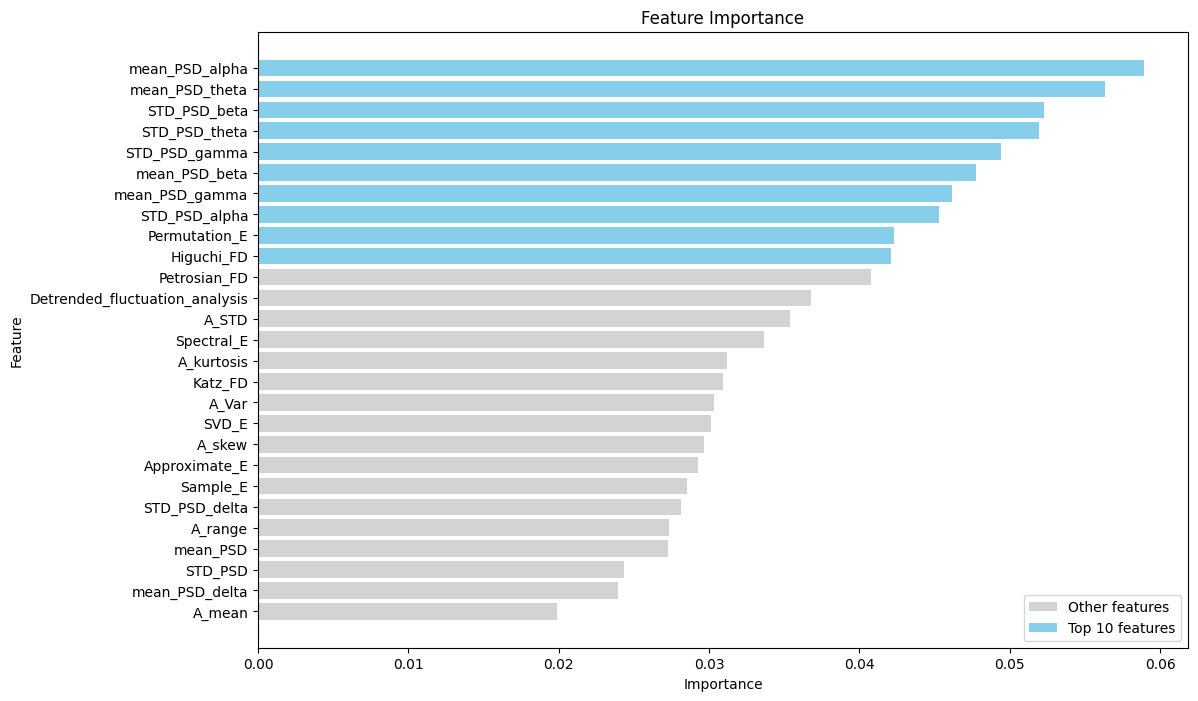

In [131]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Feature selection
X = features_df.drop(columns=['Label'])
y = features_df['Label']

# Using RandomForestClassifier for feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top 10 features
top_features = importance_df.head(10)['Feature'].values
X_top = X[top_features]

# Save the selected features to a CSV file
X_top['Label'] = y.values
X_top.to_csv('/content/drive/MyDrive/EEG Analysis/eeg_top_features.csv', index=False)

print("Feature extraction, selection, and saving completed.")

# Plot all feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgray', label='Other features')
plt.barh(importance_df.head(10)['Feature'], importance_df.head(10)['Importance'], color='skyblue', label='Top 10 features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Model Deployment


In [92]:
!pip install tensorflow keras

##1 to 9 levels as labels

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load the dataset with selected features
data = pd.read_csv('/content/drive/MyDrive/EEG Analysis/eeg_top_features.csv')

# Separate features and labels
X = data.drop(columns=['Label'])
y = data['Label']

# One-hot encode the labels for ANN
y_categorical = to_categorical(y - 1)  # assuming labels are from 1 to 9

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)

# Dictionary to store the results
results = {}

# Train and evaluate SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train_cat)
svm_y_pred = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test_cat, svm_y_pred)
results['SVM'] = svm_accuracy

# Train and evaluate KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_cat)
knn_y_pred = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test_cat, knn_y_pred)
results['KNN'] = knn_accuracy

# Train and evaluate Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train_cat)
gb_y_pred = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test_cat, gb_y_pred)
results['Gradient Boosting'] = gb_accuracy

# Train and evaluate ANN
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train_cat_scaled.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(y_categorical.shape[1], activation='softmax'))
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_model.fit(X_train_cat_scaled, y_train_cat, epochs=50, batch_size=10, validation_data=(X_test_cat_scaled, y_test_cat), verbose=0)
ann_y_pred = ann_model.predict(X_test_cat_scaled)
ann_y_pred_classes = np.argmax(ann_y_pred, axis=1) + 1  # Convert to original labels
ann_accuracy = accuracy_score(y_test, ann_y_pred_classes)
results['ANN'] = ann_accuracy

# Print classification reports
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))
print("KNN Classification Report:\n", classification_report(y_test, knn_y_pred))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gb_y_pred))
print("ANN Classification Report:\n", classification_report(y_test, ann_y_pred_classes))

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

# Print the best model
best_model = max(results, key=results.get)
print(f"The best model is {best_model} with an accuracy of {results[best_model]:.2f}")


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

##Binary classification

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load the dataset with selected features
data = pd.read_csv('/content/drive/MyDrive/EEG Analysis/eeg_top_features.csv')

# Separate features and labels
X = data.drop(columns=['Label'])
y = data['Label']

# Convert labels to binary classes
y_binary = np.where(y < 5, 0, 1)

# One-hot encode the binary labels for ANN
y_binary_categorical = to_categorical(y_binary)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_binary_categorical, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)

# Dictionary to store the results
results = {}

# SVM with GridSearchCV
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
svm_model = GridSearchCV(SVC(), svm_params, refit=True, verbose=0)
svm_model.fit(X_train_scaled, y_train)
svm_y_pred = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
results['SVM'] = svm_accuracy

# KNN with GridSearchCV
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, refit=True, verbose=0)
knn_model.fit(X_train_scaled, y_train)
knn_y_pred = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
results['KNN'] = knn_accuracy

# Gradient Boosting with GridSearchCV
gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gb_model = GridSearchCV(GradientBoostingClassifier(), gb_params, refit=True, verbose=0)
gb_model.fit(X_train_scaled, y_train)
gb_y_pred = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
results['Gradient Boosting'] = gb_accuracy

# Load the dataset with selected features
data = pd.read_csv('/content/drive/MyDrive/EEG Analysis/eeg_features.csv')

# Separate features and labels
X = data.drop(columns=['Label'])
y = data['Label']

# Convert labels to binary classes
y_binary = np.where(y < 5, 0, 1)

# One-hot encode the binary labels for ANN
y_binary_categorical = to_categorical(y_binary)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_binary_categorical, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)

# Grid Search for ANN
def create_ann_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_cat_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(y_binary_categorical.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

best_ann_accuracy = 0
best_ann_params = {}

# Hyperparameters to search
batch_sizes = [10, 20]
epochs_list = [50, 100]
optimizers = ['adam', 'rmsprop']

for batch_size in batch_sizes:
    for epochs in epochs_list:
        for optimizer in optimizers:
            ann_model = create_ann_model(optimizer)
            ann_model.fit(X_train_cat_scaled, y_train_cat, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test_cat_scaled, y_test_cat))
            ann_y_pred = ann_model.predict(X_test_cat_scaled)
            ann_y_pred_classes = np.argmax(ann_y_pred, axis=1)
            ann_accuracy = accuracy_score(y_test, ann_y_pred_classes)
            if ann_accuracy > best_ann_accuracy:
                best_ann_accuracy = ann_accuracy
                best_ann_params = {'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer}

results['ANN'] = best_ann_accuracy

# Print classification reports
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))
print("KNN Classification Report:\n", classification_report(y_test, knn_y_pred))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gb_y_pred))
print("ANN Classification Report:\n", classification_report(y_test, ann_y_pred_classes))

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

# Print the best model
best_model = max(results, key=results.get)
print(f"The best model is {best_model} with an accuracy of {results[best_model]:.2f}")


AttributeError: predict_proba is not available when probability=False